## Import Libraries

In [993]:
import os 
import pandas as pd 
import numpy as np
import seaborn as sns
import tensorflow as tf
import time 
import joblib 
import logging
import math 
import matplotlib.pyplot as plt 
import pickle
%matplotlib inline

from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dropout, Dense, LSTM, GRU, RNN, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
from pylab import rcParams

In [994]:
sns.set(color_codes = True)
col_list = ['cerulean', 'scarlet']
sns.set(style = 'white', font_scale = 1.75, palette = sns.xkcd_palette(col_list))
rcParams['figure.figsize'] = 14, 8.7

In [995]:
tf.random.set_seed(123)
seed(123)

In [996]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [997]:
LABELS = ['Normal', 'FMA']

## GPU 

In [998]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: 
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs")
    except RuntimeError as error:
        print(error)
else:
    print('No GPUs detected')

1 Physical GPUs 1 Logical GPUs


## Load Datas 

In [999]:
data = pd.read_csv('../../Datasets/Dataset_Lanzarote_Labeled.csv', sep = ';')

In [1000]:
data

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,21.0,17.88,14.0,0.0,235.00,9.2,1017.78,1016.7,1018.8,85.38,16687.50,12387.50,0
1,20.0,17.44,14.0,0.0,226.25,4.1,1020.67,1019.7,1021.9,82.99,17062.50,12062.50,0
2,23.0,19.67,16.0,0.0,58.00,8.8,1019.20,1017.5,1019.7,77.21,20733.33,12213.33,0
3,21.0,18.79,17.0,0.0,98.89,7.2,1020.30,1018.6,1021.8,87.26,12545.56,12331.58,0
4,20.0,17.67,15.0,0.0,74.67,7.2,1020.06,1019.0,1021.8,89.91,10760.00,12466.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14968,21.2,17.67,13.5,0.0,78.00,7.7,1024.31,1022.9,1025.6,74.72,20300.00,11701.20,0
14969,21.5,17.92,12.0,0.0,68.60,9.3,1023.66,1022.7,1024.1,74.92,22000.00,11696.91,0
14970,21.0,17.80,14.2,0.0,131.14,7.7,1021.48,1019.4,1023.3,70.17,6738.00,11980.96,0
14971,20.0,17.25,13.5,0.0,231.06,4.1,1019.53,1018.3,1020.8,72.75,7381.06,12973.93,0


In [1001]:
train = data[0:math.trunc(len(data) * 0.8)]
test = data[math.trunc(len(data) * 0.8):len(data)]

In [1002]:
print("Dataset shape:", data.shape)
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train + Test entries:", train.shape[0] + test.shape[0])

Dataset shape: (14973, 13)
Train shape: (11978, 13)
Test shape: (2995, 13)
Train + Test entries: 14973


## FMA Filter 

In [1003]:
train.describe()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
count,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000,11978.000000
mean,24.243530,21.081017,17.816689,0.924987,124.803976,8.979398,1017.939928,1016.634705,1019.288546,71.227233,16233.370004,13052.911175,0.022374
std,3.485548,2.915982,2.921967,11.885017,87.649668,2.852917,3.962806,4.075438,3.980226,9.951450,5798.085070,2084.078827,0.147904
min,14.000000,12.740000,0.000000,0.000000,10.000000,0.000000,992.770000,989.700000,997.100000,15.580000,210.000000,1370.590000,0.000000
25%,21.400000,18.710000,15.800000,0.000000,51.400000,7.200000,1015.520000,1014.300000,1016.800000,64.670000,12368.350000,11890.910000,0.000000
50%,24.000000,20.960000,18.000000,0.000000,97.315000,8.800000,1017.610000,1016.400000,1018.800000,70.990000,17718.800000,12848.280000,0.000000
75%,27.000000,23.410000,20.000000,0.000000,190.800000,10.800000,1020.070000,1018.800000,1021.500000,78.150000,22000.000000,14140.792500,0.000000
max,48.000000,35.990000,31.600000,637.000000,360.000000,60.700000,1034.880000,1034.000000,1037.000000,98.980000,22000.000000,25844.290000,1.000000


In [1004]:
train = train[train['FMA'] == 0]

In [1005]:
train.shape

In [1006]:
split = math.trunc(train.shape[0] * 0.2)
validation = train[-split:]
train = train[:-split]

In [1007]:
print("Validation shape:", validation.shape)
print("Train shape:", train.shape)

Validation shape: (2342, 13)
Train shape: (9368, 13)


In [1008]:
train_fma = train.iloc[:, -1]
validation_fma = validation.iloc[:, -1]
test_fma = test.iloc[:, -1]

In [1009]:
train_fma.columns = ['train_fma']
validation_fma.columns = ['validation_fma']
test_fma.columns = ['test_fma']

In [1010]:
test_fma.head()

11978    0
11979    0
11980    0
11981    0
11982    0
Name: FMA, dtype: int64

## Correlation 

In [1011]:
train.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.957446,0.840065,-0.204746,-0.120695,0.201957,-0.353428,-0.324215,-0.377891,-0.064723,0.300260,-0.084234,NaN
temp_avg,0.957446,1.000000,0.923515,-0.202081,-0.127023,0.187124,-0.371009,-0.340563,-0.396141,-0.051557,0.235236,-0.077586,NaN
temp_min,0.840065,0.923515,1.000000,-0.160378,-0.170390,0.248507,-0.337623,-0.310412,-0.358837,-0.005967,0.089087,-0.084434,NaN
prec,-0.204746,-0.202081,-0.160378,1.000000,0.232481,0.015744,-0.185216,-0.207244,-0.158453,0.117970,-0.163819,0.008069,NaN
wd,-0.120695,-0.127023,-0.170390,0.232481,1.000000,-0.339870,-0.363680,-0.380591,-0.335221,0.118993,-0.107645,0.134661,NaN
ws,0.201957,0.187124,0.248507,0.015744,-0.339870,1.000000,-0.091072,-0.088722,-0.094435,-0.050993,0.061347,-0.117124,NaN
atmos_pres_avg,-0.353428,-0.371009,-0.337623,-0.185216,-0.363680,-0.091072,1.000000,0.986306,0.989342,-0.150020,0.086582,0.013588,NaN
atmos_pres_min,-0.324215,-0.340563,-0.310412,-0.207244,-0.380591,-0.088722,0.986306,1.000000,0.961231,-0.146653,0.092579,0.017246,NaN
atmos_pres_max,-0.377891,-0.396141,-0.358837,-0.158453,-0.335221,-0.094435,0.989342,0.961231,1.000000,-0.146832,0.077420,0.010458,NaN
rh,-0.064723,-0.051557,-0.005967,0.117970,0.118993,-0.050993,-0.150020,-0.146653,-0.146832,1.000000,-0.044667,0.107719,NaN


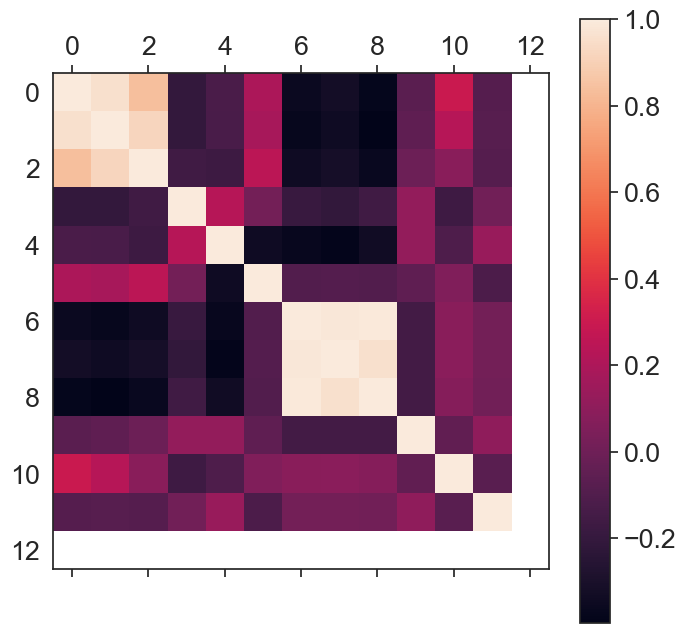

In [1012]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

In [1013]:
test.corr()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
temp_max,1.000000,0.955293,0.857029,-0.093206,0.183276,0.219135,-0.456372,-0.427963,-0.486952,-0.062056,0.157398,-0.076844,0.323990
temp_avg,0.955293,1.000000,0.947432,-0.082988,0.190518,0.197887,-0.484843,-0.452314,-0.518675,-0.048093,0.127917,-0.062117,0.275481
temp_min,0.857029,0.947432,1.000000,-0.072185,0.156173,0.257880,-0.468683,-0.436645,-0.502474,-0.008593,0.065753,-0.114442,0.197936
prec,-0.093206,-0.082988,-0.072185,1.000000,0.051716,0.082812,-0.220524,-0.244565,-0.179207,0.125364,-0.030768,-0.076908,0.369885
wd,0.183276,0.190518,0.156173,0.051716,1.000000,0.067182,-0.457296,-0.449719,-0.455374,-0.028508,-0.045057,-0.029150,-0.005854
ws,0.219135,0.197887,0.257880,0.082812,0.067182,1.000000,-0.119874,-0.131237,-0.110763,-0.185214,0.020122,-0.221089,0.127765
atmos_pres_avg,-0.456372,-0.484843,-0.468683,-0.220524,-0.457296,-0.119874,1.000000,0.992434,0.987808,-0.113435,-0.027684,0.141509,-0.204795
atmos_pres_min,-0.427963,-0.452314,-0.436645,-0.244565,-0.449719,-0.131237,0.992434,1.000000,0.966190,-0.118095,-0.030923,0.145612,-0.213701
atmos_pres_max,-0.486952,-0.518675,-0.502474,-0.179207,-0.455374,-0.110763,0.987808,0.966190,1.000000,-0.109262,-0.025579,0.137578,-0.188528
rh,-0.062056,-0.048093,-0.008593,0.125364,-0.028508,-0.185214,-0.113435,-0.118095,-0.109262,1.000000,-0.090142,-0.235552,-0.205908


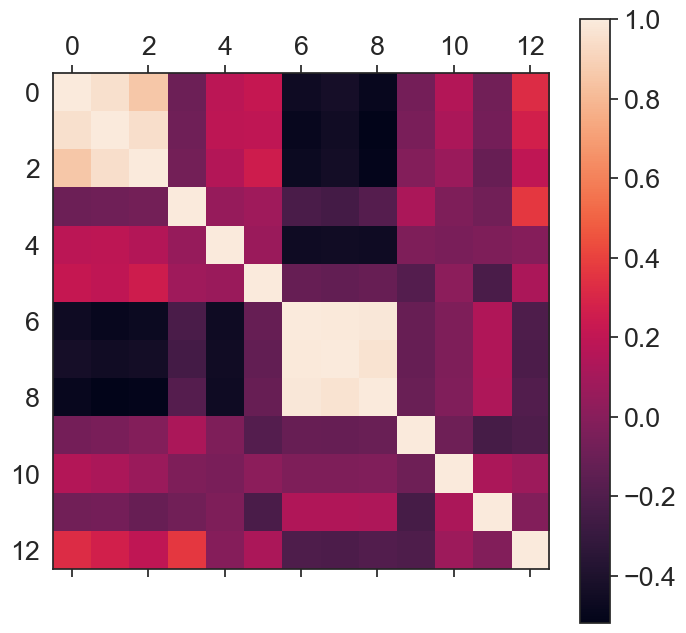

In [1014]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(test.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Update Datas

In [1015]:
train = train.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [1016]:
test = test.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [1017]:
validation = validation.drop(['temp_max', 'temp_min', 'atmos_pres_min', 'atmos_pres_max', 'ceil_hgt', 'visibility', 'FMA'], axis = 1)

In [1018]:
print('Training shape:', train.shape)
print('Test shape:', test.shape)
print('Validation shape:', validation.shape)

Training shape: (9368, 6)
Test shape: (2995, 6)
Validation shape: (2342, 6)


In [1019]:
train.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.202081,-0.127023,0.187124,-0.371009,-0.051557
prec,-0.202081,1.000000,0.232481,0.015744,-0.185216,0.117970
wd,-0.127023,0.232481,1.000000,-0.339870,-0.363680,0.118993
ws,0.187124,0.015744,-0.339870,1.000000,-0.091072,-0.050993
atmos_pres_avg,-0.371009,-0.185216,-0.363680,-0.091072,1.000000,-0.150020
rh,-0.051557,0.117970,0.118993,-0.050993,-0.150020,1.000000


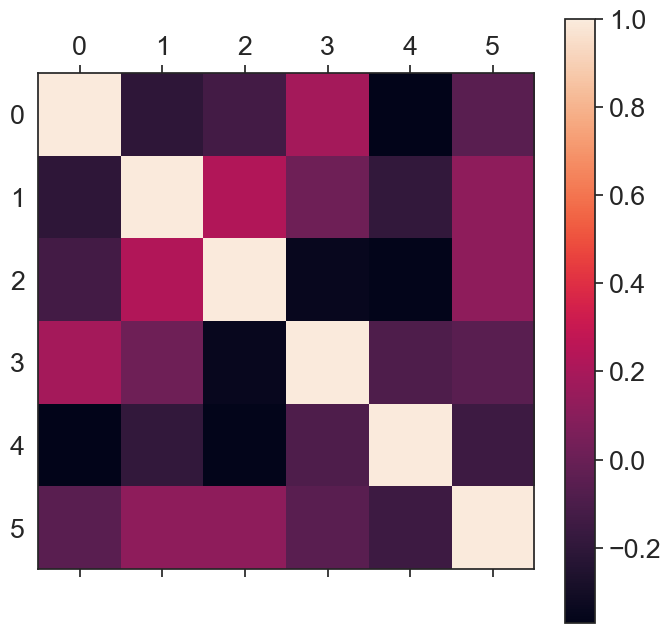

In [1020]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(train.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

In [1021]:
test.corr()

,temp_avg,prec,wd,ws,atmos_pres_avg,rh
temp_avg,1.000000,-0.082988,0.190518,0.197887,-0.484843,-0.048093
prec,-0.082988,1.000000,0.051716,0.082812,-0.220524,0.125364
wd,0.190518,0.051716,1.000000,0.067182,-0.457296,-0.028508
ws,0.197887,0.082812,0.067182,1.000000,-0.119874,-0.185214
atmos_pres_avg,-0.484843,-0.220524,-0.457296,-0.119874,1.000000,-0.113435
rh,-0.048093,0.125364,-0.028508,-0.185214,-0.113435,1.000000


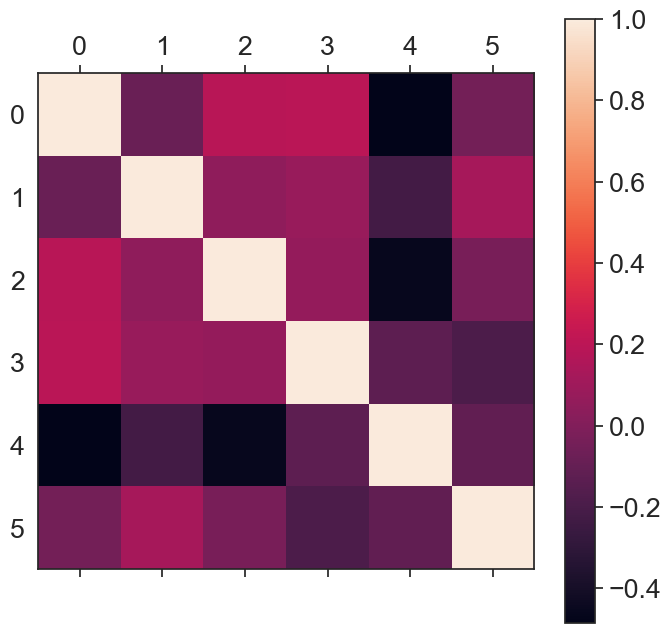

In [1022]:
figure = plt.figure(figsize = (8,8), dpi = 100)
ax = figure.add_subplot(111)
cax = ax.matshow(test.corr(), interpolation = 'nearest')
figure.colorbar(cax)
plt.show()

## Data Normalization 

In [1023]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
x_validation = scaler.transform(validation)
scaler_filename = 'scaler_data_Lanzarote'
joblib.dump(scaler, scaler_filename)

['scaler_data_Lanzarote']

In [1024]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_validation shape:', x_validation.shape)

x_train shape: (9368, 6)
x_test shape: (2995, 6)
x_validation shape: (2342, 6)


In [1025]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1])

In [1026]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_validation shape:', x_validation.shape)

x_train shape: (9368, 1, 6)
x_test shape: (2995, 1, 6)
x_validation shape: (2342, 1, 6)


## Model 

In [1027]:
def autoencoder_model_LSTM(X):
    inputs = Input(shape = (X.shape[1], X.shape[2]))
    
    L1 = LSTM(16, activation = 'relu', return_sequences = True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
    L2 = Dropout(0.2)(L1)
    L3 = LSTM(4, activation = 'relu', return_sequences = False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation = 'relu', return_sequences = True)(L4)
    L6 = Dropout(0.2)(L5)
    L7 = LSTM(16, activation = 'relu', return_sequences = True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(L6)
    
    outputs = TimeDistributed(Dense(X.shape[2]))(L7)
    
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [1028]:
model = autoencoder_model_LSTM(x_train)
model.compile(optimizer = 'adamax', loss = 'mae', metrics = ['mae', 'mse', 'mape', 'msle', 'cosine_proximity'])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1, 6)]            0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 1, 16)             1472      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 16)             0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 1, 4)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 4)              0  

## Training 

In [1029]:
dataframe_train = DataFrame()
dataframe_validation = DataFrame()

early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

for i in range(1):
    print('Fit model on training data...')
    start = time.time()
    epochs = 300
    batch_size = 128
    
    history = model.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_validation, x_validation), verbose = 0, callbacks=[early_stopping_callback]).history
    
    end = time.time()
    
    dataframe_train[str(i)] = history['loss']
    dataframe_validation[str(i)] = history['val_loss']
    
    print('Time to training model:', end - start)

Fit model on training data...
Time to training model: 680.8735013008118


## Training Results

In [1030]:
loss = model.evaluate(x_train, x_train, verbose = 0)
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.07511759549379349
mae 0.07430370151996613
mse 0.012050364166498184
mape 113207.03125
msle 0.00564399641007185
cosine_proximity 0.9769982695579529


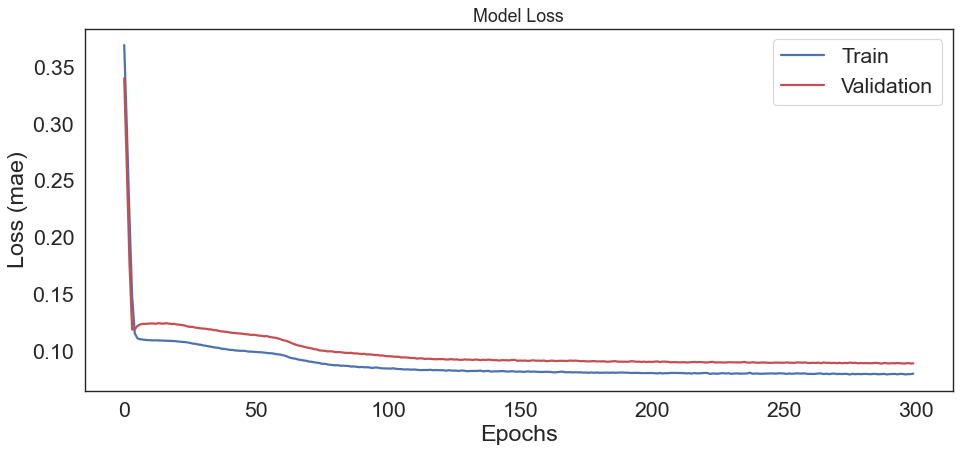

In [1031]:
figure, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['loss'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_loss'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize = 16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epochs')
ax.legend(loc = 'upper right')
plt.show()

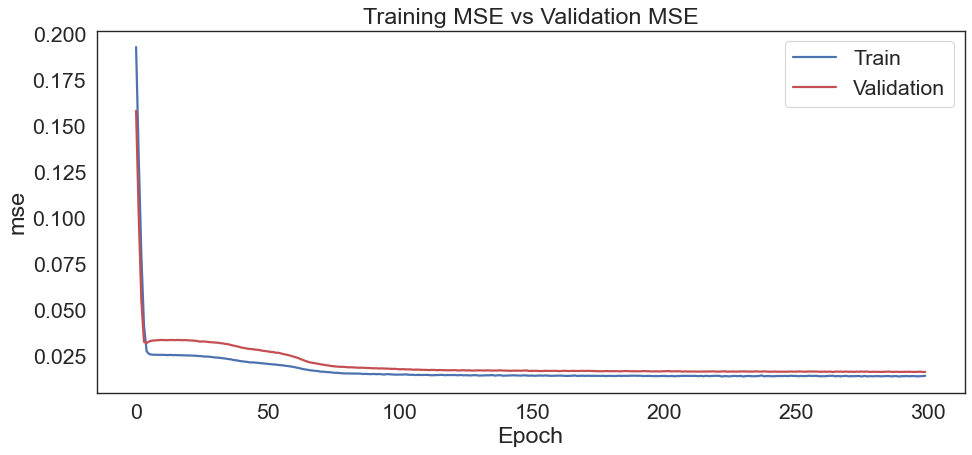

In [1032]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'b', label = 'Train', linewidth = 2)
ax.plot(history['val_mse'], 'r', label = 'Validation', linewidth = 2)
ax.set_title('Training MSE vs Validation MSE')
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc = 'upper right')
plt.show()

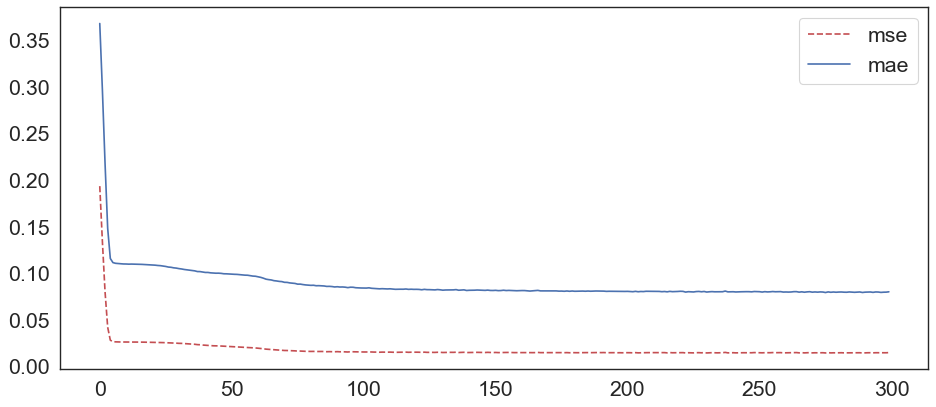

In [1033]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history['mse'], 'r--', label = 'mse')
ax.plot(history['mae'], 'b', label = 'mae')
ax.legend(loc = 'upper right')
plt.show()

### Distribution of Loss Function 

In [1058]:
x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = train.columns)
x_pred.index = train.index

In [1059]:
scored = pd.DataFrame(index = train.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred - Xtrain), axis = 1)

D:\TFG\Environment\TFG\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


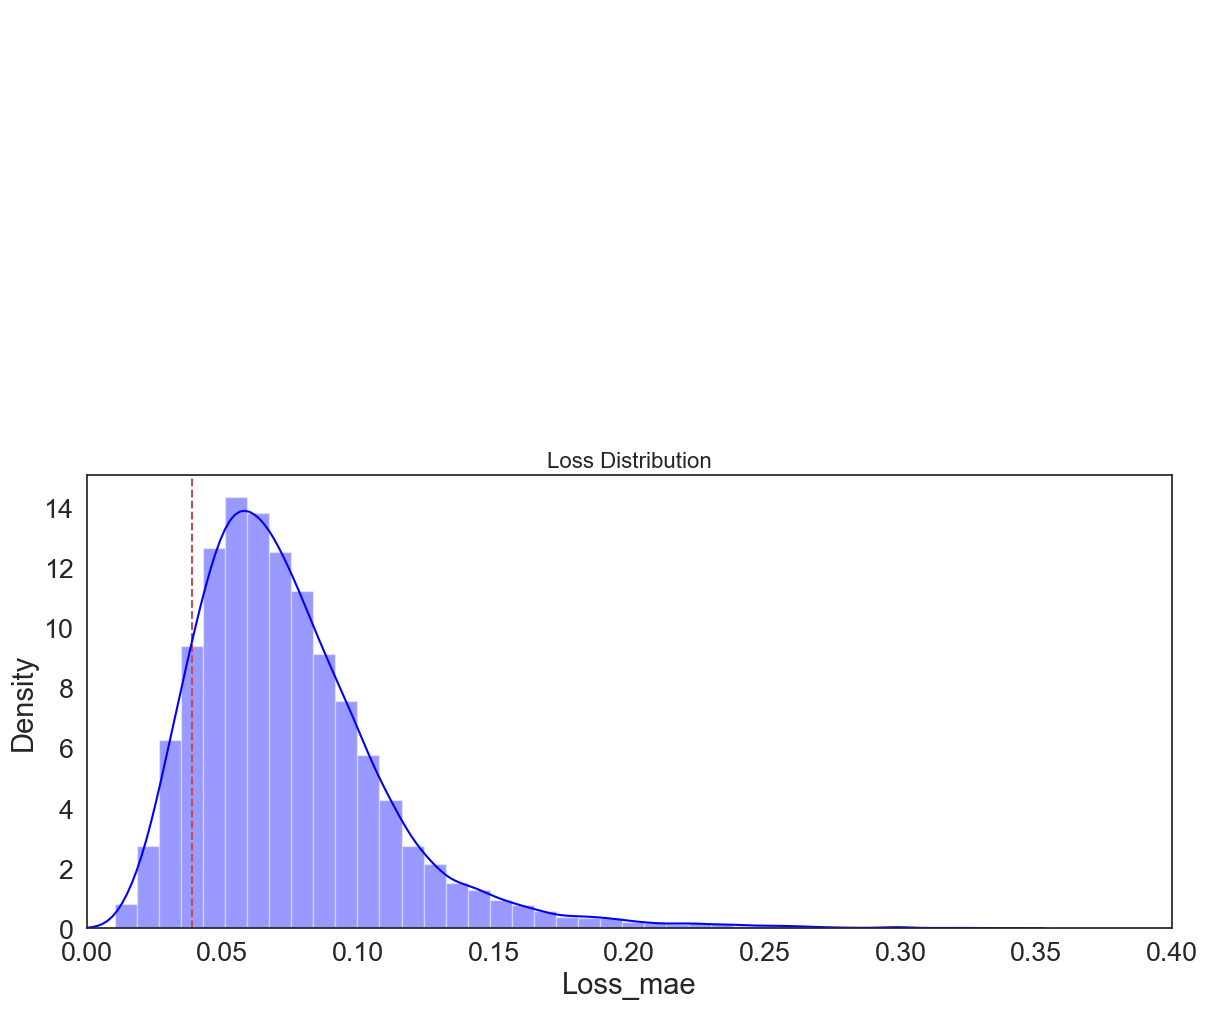

In [1060]:
plt.figure(figsize = (14, 6), dpi = 100)
plt.title('Loss Distribution', fontsize = 16)
plt.axvline(0.039, ls = '--', color = 'r')
plt.annotate('Threshold = 0.039', xy = (0.06, 30), xycoords = 'data', fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
sns.distplot(scored['Loss_mae'], bins = 40, kde = True, color = 'blue')
plt.xlim([0.0, .4])

## Test Predictions 

In [1061]:
x_pred = model.predict(x_test)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns = test.columns)
x_pred.index = test.index

In [1062]:
error_dataframe = pd.DataFrame(index = test.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
error_dataframe['Reconstruction_error'] = np.mean(np.power(x_pred - Xtest, 2), axis = 1)
error_dataframe['True_class'] = test_fma
error_dataframe.head()

,Reconstruction_error,True_class
11978,0.004853,0
11979,0.007942,0
11980,0.014488,0
11981,0.007117,0
11982,0.001571,0


In [1063]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)

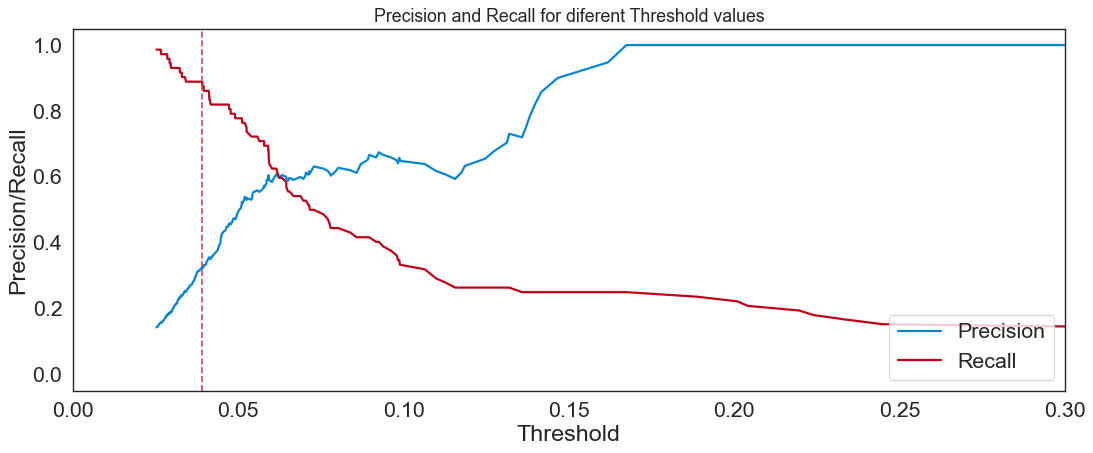

In [1064]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(threshold, precision[1:], label = 'Precision', linewidth = 2)
ax.plot(threshold, recall[1:], label = 'Recall', linewidth = 2)
ax.set_title('Precision and Recall for diferent Threshold values', fontsize = 16)
ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')
ax.set_xlim([0.0, 0.3])
ax.axvline(0.039, ls = '--', color = 'r')
ax.legend(loc = 'lower right')
plt.show()

### ROC Curve Check

In [1065]:
false_pos_rate, true_pos_rate, threshold = roc_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

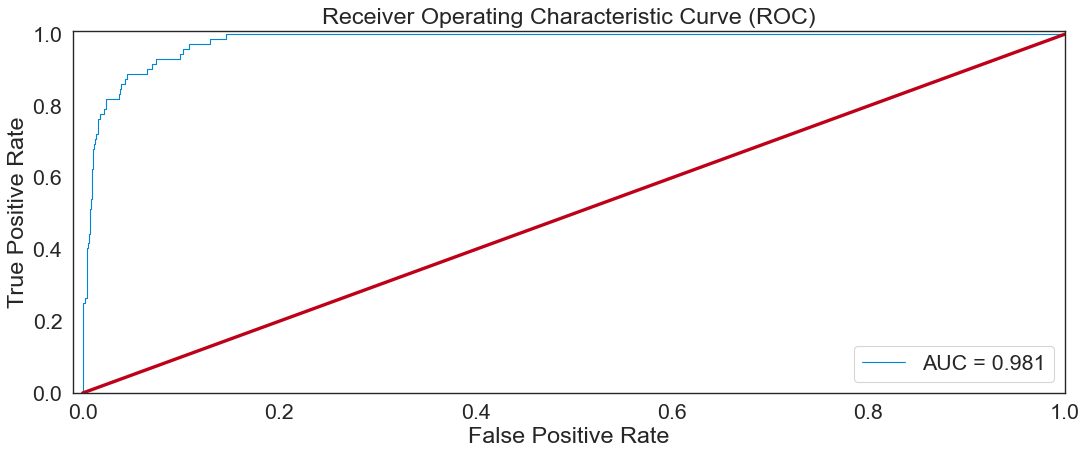

In [1066]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(false_pos_rate, true_pos_rate, linewidth = 1, label = 'AUC = %0.3f' % roc_auc)
ax.plot([0,1], [0,1], linewidth = 3)
ax.set_title('Receiver Operating Characteristic Curve (ROC)')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.legend(loc = 'lower right')
plt.show()

### Recall VS Precision Thresholding 

In [1067]:
precision, recall, threshold = precision_recall_curve(error_dataframe.True_class, error_dataframe.Reconstruction_error)

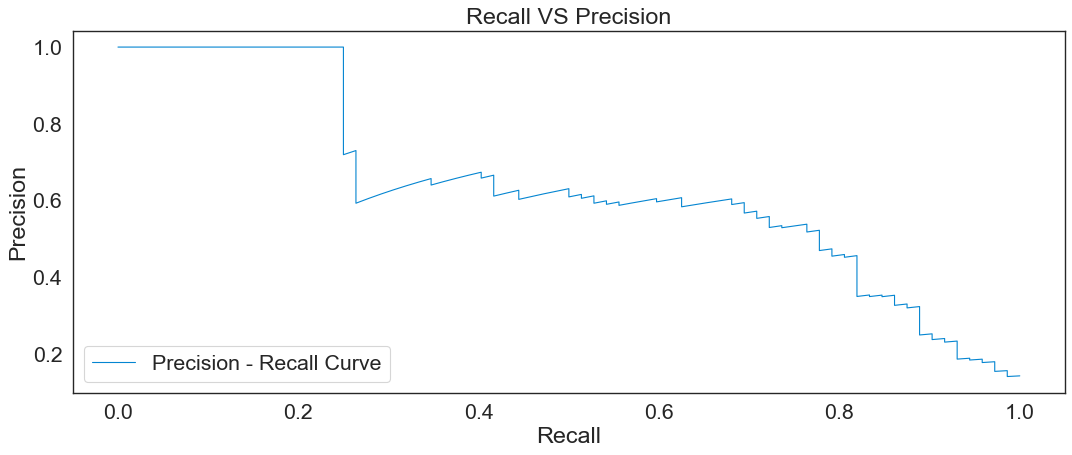

In [1068]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 80)
ax.plot(recall, precision, linewidth = 1, label = 'Precision - Recall Curve')
ax.set_title('Recall VS Precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend(loc = 'lower left')
plt.show()

### Reconstruction Error VS Threshold Check

In [1069]:
threshold_fixed = 0.039
groups = error_dataframe.groupby('True_class')

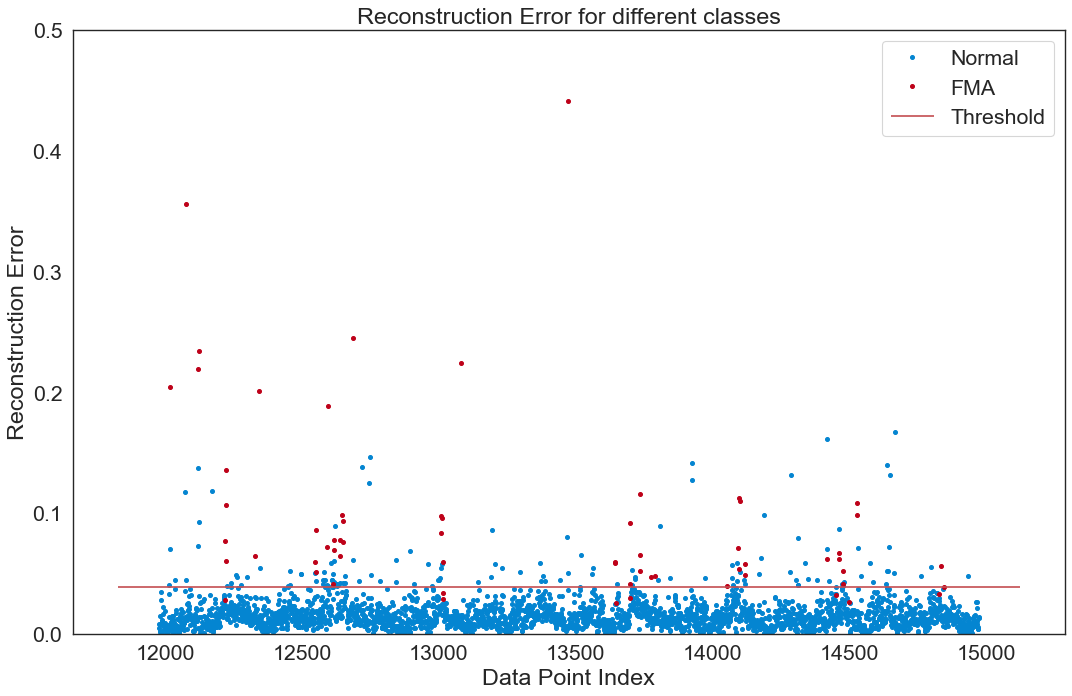

In [1070]:
fig, ax = plt.subplots(figsize = (16, 10), dpi = 80)

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '', label = 'FMA' if name == 1 else 'Normal')
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder = 100, label = 'Threshold')
ax.set_title('Reconstruction Error for different classes')
ax.set_ylabel('Reconstruction Error')
ax.set_xlabel('Data Point Index')
ax.set_ylim([0, 0.5])
ax.legend(loc = 'upper right')
plt.show()

### Confusion Matrix 

In [1071]:
pred_y = [1 if error > threshold_fixed else 0 for error in error_dataframe.Reconstruction_error.values]

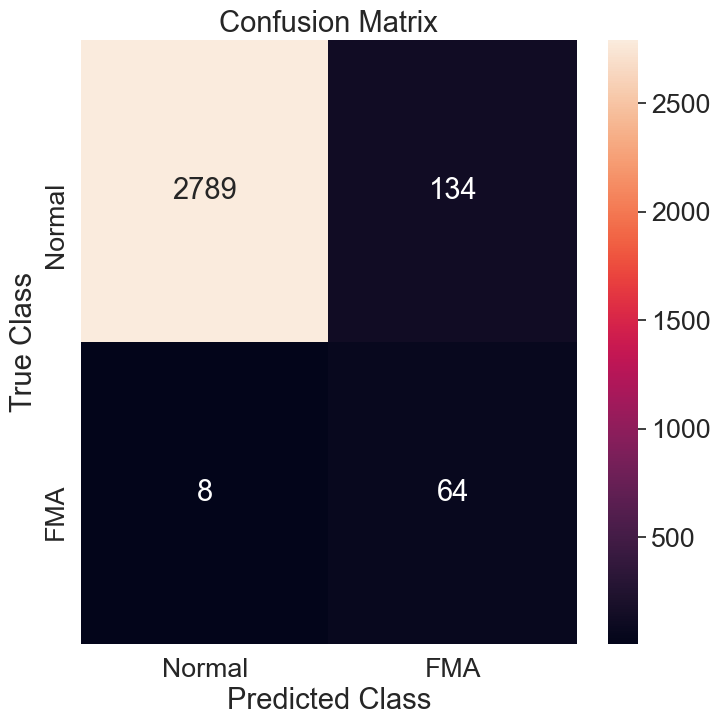

In [1072]:
matrix = confusion_matrix(error_dataframe.True_class, pred_y)
fig, ax = plt.subplots(figsize = (8, 8), dpi = 100)
sns.heatmap(matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
plt.show()

### Reconstruction Error - Test Set 

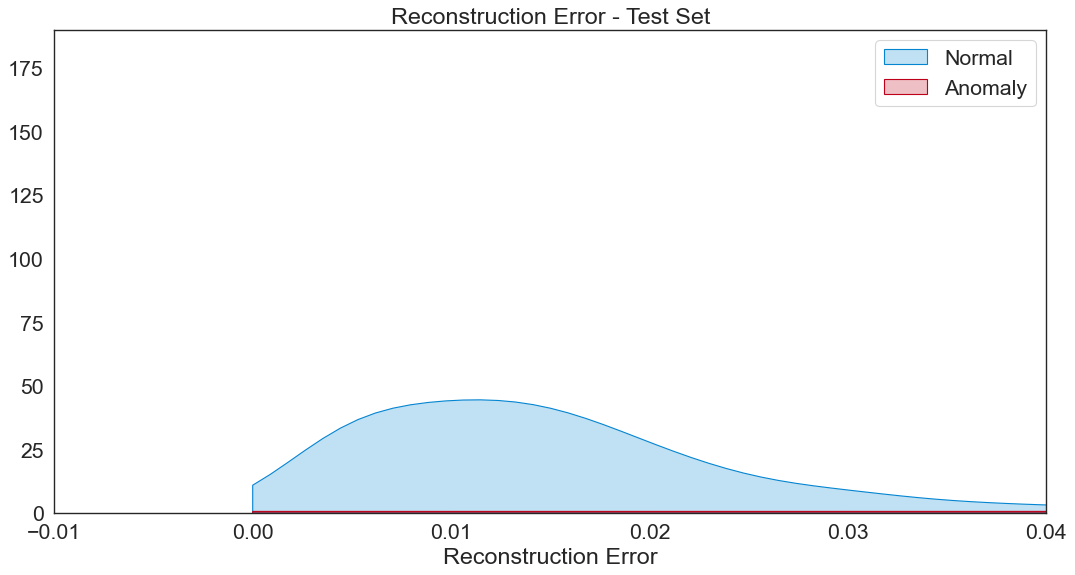

In [1073]:
fig, ax = plt.subplots(figsize = (16, 8), dpi = 80)
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 0], label = 'Normal', shade = True, clip = (0, 10))
sns.kdeplot(error_dataframe.Reconstruction_error[error_dataframe.True_class == 1], label = 'Anomaly', shade = True, clip = (0, 10))
ax.set_title('Reconstruction Error - Test Set')
ax.set_xlim([-0.01, 0.04])
ax.set_ylim([0, 190])
ax.set_xlabel('Reconstruction Error')
ax.set_ylabel('')
ax.legend(loc = 'upper right')
plt.show()

## Thresholds 

### Threshold with Max  

In [1074]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_max = np.max(train_loss)
print("Reconstruction error threshold with max: ", threshold_max)

Reconstruction error threshold with max:  1.000038837082684


### Threshold with Mean and Std

In [1075]:
x_train_pred = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)
threshold_mean_std = np.mean(train_loss) + np.std(train_loss)
print("Reconstruction error threshold with mean and std: ", threshold_mean_std)

Reconstruction error threshold with mean and std:  0.15510790607383457


### Threshold Precision ∩ Recall

In [1076]:
def intersection_point():
    precision_points = np.array([[threshold[i],precision[i]] for i in range(len(precision[1:]))])
    recall_points = np.array([[threshold[i],recall[i]] for i in range(len(recall[1:]))])
    nrows, ncols = precision_points.shape
    dtype = {'names': ['f{}'.format(i) for i in range(ncols)], 'formats': ncols * [precision_points.dtype]}
    intersection = np.intersect1d(precision_points.view(dtype), recall_points.view(dtype))
    return intersection.view(precision_points.dtype).reshape(-1, ncols)

In [1077]:
threshold_precision_recall = intersection_point()[0][0]

In [1078]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}\n".format(ll))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred, target_names = LABELS))
    print("Fbeta Score(0.5):{:.3f}".format(fbeta_score(ytest, ypred, average="micro", beta=0.5)))

In [1079]:
threshold_fixed = [threshold_max, threshold_mean_std, threshold_precision_recall]

print('------------------------------------------------------------------------------')

for threshold in threshold_fixed: 
    pred_y = [1 if error > threshold else 0 for error in error_dataframe.Reconstruction_error.values]
    matrix = confusion_matrix(error_dataframe.True_class, pred_y)
    
    precision = precision_score(error_dataframe.True_class, pred_y, average = 'weighted')
    recall = recall_score(error_dataframe.True_class, pred_y, average = 'weighted')
    fbeta = fbeta_score(error_dataframe.True_class, pred_y, beta = 0.5)
    
    print('Result:\n')
    print('Precision Score = %.3f\nRecall Score = %.3f\nFbeta Score = %.3f\n' % (precision, recall, fbeta))
    print('Threshold fixed = %.3f' % threshold)
    print_stats(error_dataframe.True_class, pred_y)
    print('------------------------------------------------------------------------------')

------------------------------------------------------------------------------
Result:

Precision Score = 0.978
Recall Score = 0.978
Fbeta Score = 0.312

Threshold fixed = 1.000
Accuracy: 0.97796, Cohen's Kappa Score: 0.15071
Log Loss: 0.7611216167158957

Confusion Matrix:
[[2923    0]
 [  66    6]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      2923
         FMA       1.00      0.08      0.15        72

    accuracy                           0.98      2995
   macro avg       0.99      0.54      0.57      2995
weighted avg       0.98      0.98      0.97      2995

Fbeta Score(0.5):0.978
------------------------------------------------------------------------------
Result:

Precision Score = 0.980
Recall Score = 0.981
Fbeta Score = 0.592

Threshold fixed = 0.155
Accuracy: 0.98130, Cohen's Kappa Score: 0.38487
Log Loss: 0.645800693592608

Confusion Matrix:
[[2921    2]
 [  54   18]]
Classification Report:
   

### Historic

In [1082]:
#model.save('../../Historical/Lanzarote/LSTM_LANZAROTE.h5')

In [1083]:
#with open('../../Historical/Lanzarote/LSTM_LANZAROTE.txt', 'wb') as file_pi:
#    pickle.dump(history, file_pi)